# 📊 Demo: Análisis de Datos UAM

## Sistema de Gestión de Datos Universitarios

Este notebook demuestra el análisis de datos de la Universidad Autónoma de Madrid (UAM) desde 2017 hasta 2025.

**Fuentes de datos:**
- Presupuestos de Gastos e Ingresos
- Convocatorias de Ayudas
- Licitaciones y Contratos

**Tecnologías:**
- PostgreSQL 16 con pgVector
- Python + pandas para análisis
- Docker para orquestación

## 🔧 Configuración Inicial

In [42]:
# Instalar dependencias (solo si es necesario)
# %pip install psycopg2-binary pandas matplotlib seaborn

In [43]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [44]:
# Conexión a PostgreSQL
conn = psycopg2.connect(
    host='localhost',
    port=5432,
    user='myuser',
    password='mypassword',
    database='mydb'
)

print("✅ Conexión exitosa a PostgreSQL")

✅ Conexión exitosa a PostgreSQL


## 📈 1. Resumen General de Datos

In [45]:
# Conteo de registros por tabla
query = """
SELECT 
    'UNIVERSIDAD' as tabla, COUNT(*) as registros FROM universidad
UNION ALL
SELECT 
    'PRESUPUESTO_GASTOS' as tabla, COUNT(*) as registros FROM presupuesto_gastos
UNION ALL
SELECT 
    'PRESUPUESTO_INGRESOS' as tabla, COUNT(*) as registros FROM presupuesto_ingresos
UNION ALL
SELECT 
    'CONVOCATORIA_AYUDA' as tabla, COUNT(*) as registros FROM convocatoria_ayuda
UNION ALL
SELECT 
    'AYUDA' as tabla, COUNT(*) as registros FROM ayuda
UNION ALL
SELECT 
    'LICITACION' as tabla, COUNT(*) as registros FROM licitacion
ORDER BY registros DESC;
"""

df_resumen = pd.read_sql_query(query, conn)
df_resumen

/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/3823762086.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resumen = pd.read_sql_query(query, conn)


,tabla,registros
0,PRESUPUESTO_GASTOS,94356
1,PRESUPUESTO_INGRESOS,15664
2,AYUDA,6390
3,LICITACION,433
4,CONVOCATORIA_AYUDA,12
5,UNIVERSIDAD,1


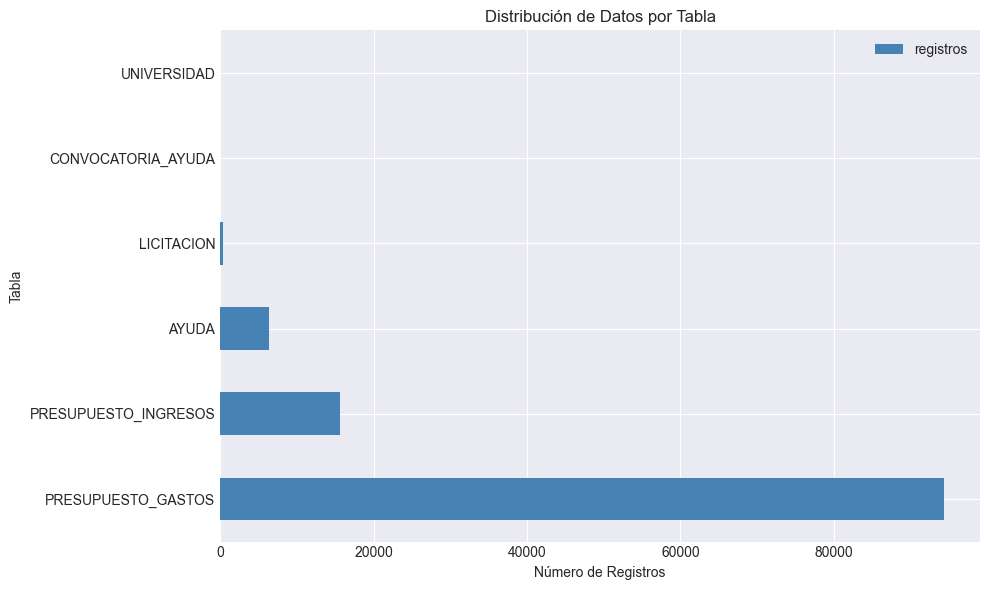

In [46]:
# Visualización del resumen
fig, ax = plt.subplots(figsize=(10, 6))
df_resumen.plot(x='tabla', y='registros', kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Número de Registros')
ax.set_ylabel('Tabla')
ax.set_title('Distribución de Datos por Tabla')
plt.tight_layout()
plt.show()

## 💰 2. Análisis de Presupuestos

### 2.1 Evolución del Presupuesto por Año

In [47]:
# Presupuesto total por año (gastos e ingresos)
query = """
SELECT 
    anio,
    SUM(credito_total) as total_gastos
FROM presupuesto_gastos
WHERE anio IS NOT NULL
GROUP BY anio
ORDER BY anio;
"""

df_gastos_anio = pd.read_sql_query(query, conn)

query = """
SELECT 
    anio,
    SUM(credito_total) as total_ingresos
FROM presupuesto_ingresos
WHERE anio IS NOT NULL
GROUP BY anio
ORDER BY anio;
"""

df_ingresos_anio = pd.read_sql_query(query, conn)

# Combinar gastos e ingresos
df_presupuesto = pd.merge(df_gastos_anio, df_ingresos_anio, on='anio', how='outer')
df_presupuesto = df_presupuesto.fillna(0)
df_presupuesto

/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/3298943761.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_gastos_anio = pd.read_sql_query(query, conn)
/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/3298943761.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ingresos_anio = pd.read_sql_query(query, conn)


,anio,total_gastos,total_ingresos
0,2017,2.883932e+08,2.883932e+08
1,2018,2.954302e+08,2.954302e+08
2,2019,3.154899e+08,3.154899e+08
3,2020,3.260863e+08,3.260863e+08
4,2021,6.813788e+08,6.813788e+08
5,2022,7.784233e+08,7.784233e+08
6,2023,7.926207e+08,7.935096e+08
7,2024,7.862313e+08,7.862313e+08
8,2025,3.314761e+08,3.314761e+08


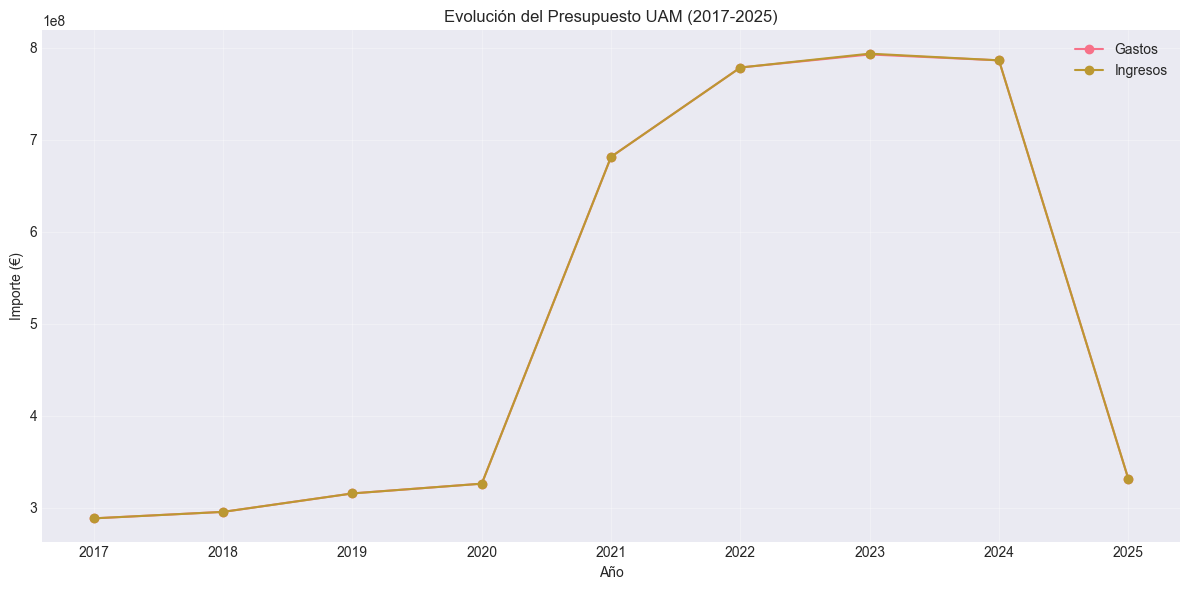

In [48]:
# Visualización de la evolución
fig, ax = plt.subplots(figsize=(12, 6))
df_presupuesto.plot(x='anio', y=['total_gastos', 'total_ingresos'], ax=ax, marker='o')
ax.set_xlabel('Año')
ax.set_ylabel('Importe (€)')
ax.set_title('Evolución del Presupuesto UAM (2017-2025)')
ax.legend(['Gastos', 'Ingresos'])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 2.2 Distribución de Gastos por Capítulo

In [49]:
# Top 10 capítulos de gastos
query = """
SELECT 
    des_capitulo,
    SUM(credito_total) as total
FROM presupuesto_gastos
WHERE des_capitulo IS NOT NULL AND des_capitulo != ''
GROUP BY des_capitulo
ORDER BY total DESC
LIMIT 10;
"""

df_capitulos = pd.read_sql_query(query, conn)
df_capitulos['total_millones'] = df_capitulos['total'] / 1_000_000
df_capitulos

/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/1459475222.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_capitulos = pd.read_sql_query(query, conn)


,des_capitulo,total,total_millones
0,GASTOS DE PERSONAL,2.227831e+09,2227.830906
1,INVERSIONES REALES,1.402882e+09,1402.882338
2,GASTOS CORRIENTES EN BIENES Y SERVICIOS,5.907128e+08,590.712793
3,TRANSFERENCIAS CORRIENTES,2.008610e+08,200.860989
4,TRANSFERENCIAS DE CAPITAL,1.318575e+08,131.857460
5,PASIVOS FINANCIEROS,3.126474e+07,31.264736
6,ACTIVOS FINANCIEROS,6.500000e+06,6.500000
7,GASTOS FINANCIEROS,3.620640e+06,3.620640


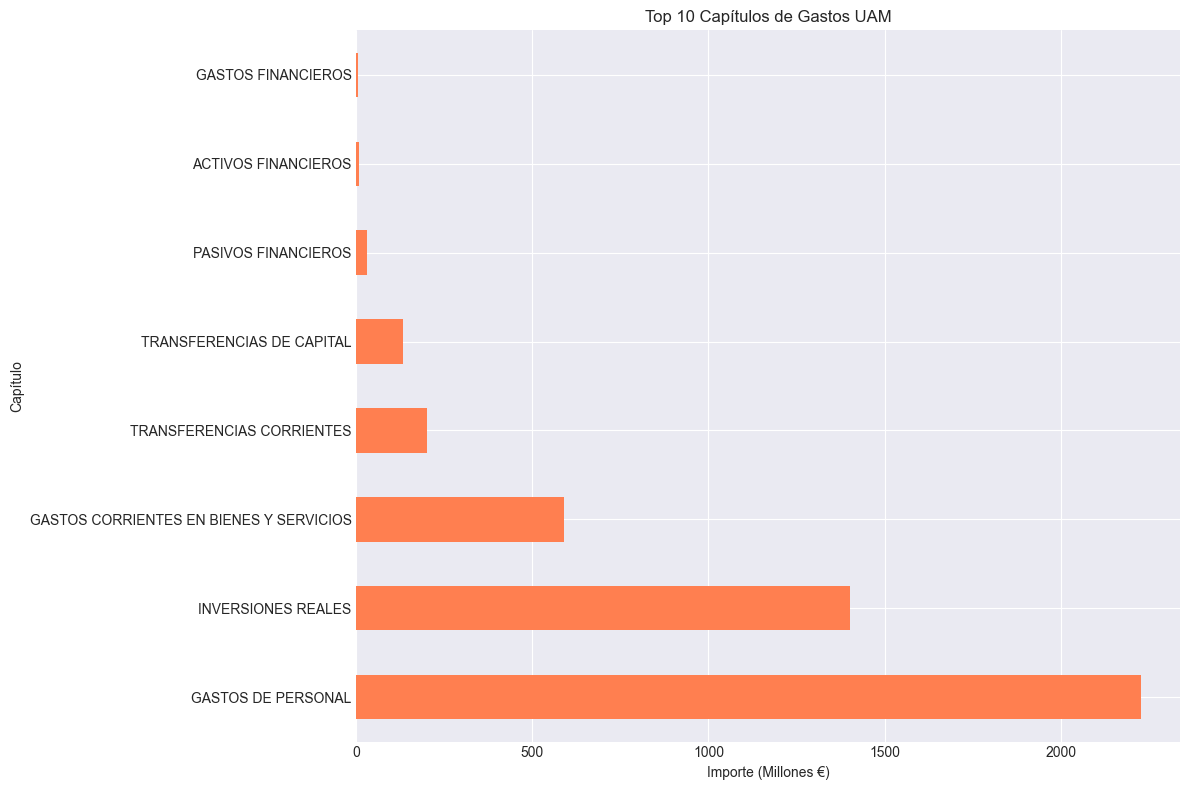

In [50]:
# Gráfico de barras de los principales capítulos
fig, ax = plt.subplots(figsize=(12, 8))
df_capitulos.plot(x='des_capitulo', y='total_millones', kind='barh', ax=ax, color='coral')
ax.set_xlabel('Importe (Millones €)')
ax.set_ylabel('Capítulo')
ax.set_title('Top 10 Capítulos de Gastos UAM')
ax.legend().remove()
plt.tight_layout()
plt.show()

## 🎓 3. Análisis de Ayudas y Convocatorias

### 3.1 Estadísticas de Ayudas

In [51]:
# Estadísticas de ayudas por categoría
query = """
SELECT 
    c.des_categoria,
    COUNT(a.id_ayuda) as num_ayudas,
    SUM(a.cuantia_total) as total_cuantia,
    AVG(a.cuantia_total) as media_cuantia,
    MAX(a.cuantia_total) as max_cuantia
FROM ayuda a
JOIN convocatoria_ayuda c ON a.cod_convocatoria_ayuda = c.cod_convocatoria
WHERE c.des_categoria IS NOT NULL AND c.des_categoria != ''
GROUP BY c.des_categoria
ORDER BY total_cuantia DESC;
"""

df_ayudas_cat = pd.read_sql_query(query, conn)
df_ayudas_cat

/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/2942108398.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ayudas_cat = pd.read_sql_query(query, conn)


,des_categoria,num_ayudas,total_cuantia,media_cuantia,max_cuantia
0,FormaciÃ³n de investigadores e investigadoras,2216,16275941.70,7344.739034,22031.52
1,Becas y ayudas,2963,6599877.64,2227.430861,9444.20
2,ColaboraciÃ³n,1211,322040.00,265.928984,1800.00


In [52]:
# Top 10 ayudas más cuantiosas
query = """
SELECT 
    c.nombre_convocatoria,
    c.des_categoria,
    a.cuantia_total,
    c.fecha_inicio_solicitudes,
    c.fecha_fin_solicitudes
FROM ayuda a
JOIN convocatoria_ayuda c ON a.cod_convocatoria_ayuda = c.cod_convocatoria
WHERE a.cuantia_total IS NOT NULL
ORDER BY a.cuantia_total DESC
LIMIT 10;
"""

df_top_ayudas = pd.read_sql_query(query, conn)
df_top_ayudas

/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/2199746243.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top_ayudas = pd.read_sql_query(query, conn)


,nombre_convocatoria,des_categoria,cuantia_total,fecha_inicio_solicitudes,fecha_fin_solicitudes
0,Convocatoria del Programa Propio de Ayudas par...,FormaciÃ³n de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
1,Convocatoria del Programa Propio de Ayudas par...,FormaciÃ³n de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
2,Convocatoria del Programa Propio de Ayudas par...,FormaciÃ³n de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
3,Convocatoria del Programa Propio de Ayudas par...,FormaciÃ³n de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
4,Convocatoria del Programa Propio de Ayudas par...,FormaciÃ³n de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
5,Convocatoria del Programa Propio de Ayudas par...,FormaciÃ³n de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
6,Convocatoria del Programa Propio de Ayudas par...,FormaciÃ³n de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
7,Convocatoria del Programa Propio de Ayudas par...,FormaciÃ³n de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
8,Convocatoria del Programa Propio de Ayudas par...,FormaciÃ³n de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20
9,Convocatoria del Programa Propio de Ayudas par...,FormaciÃ³n de investigadores e investigadoras,22031.52,2017-04-05,2017-04-20


### 3.2 Distribución de Cuantías de Ayudas

/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/2083866062.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cuantias = pd.read_sql_query(query, conn)


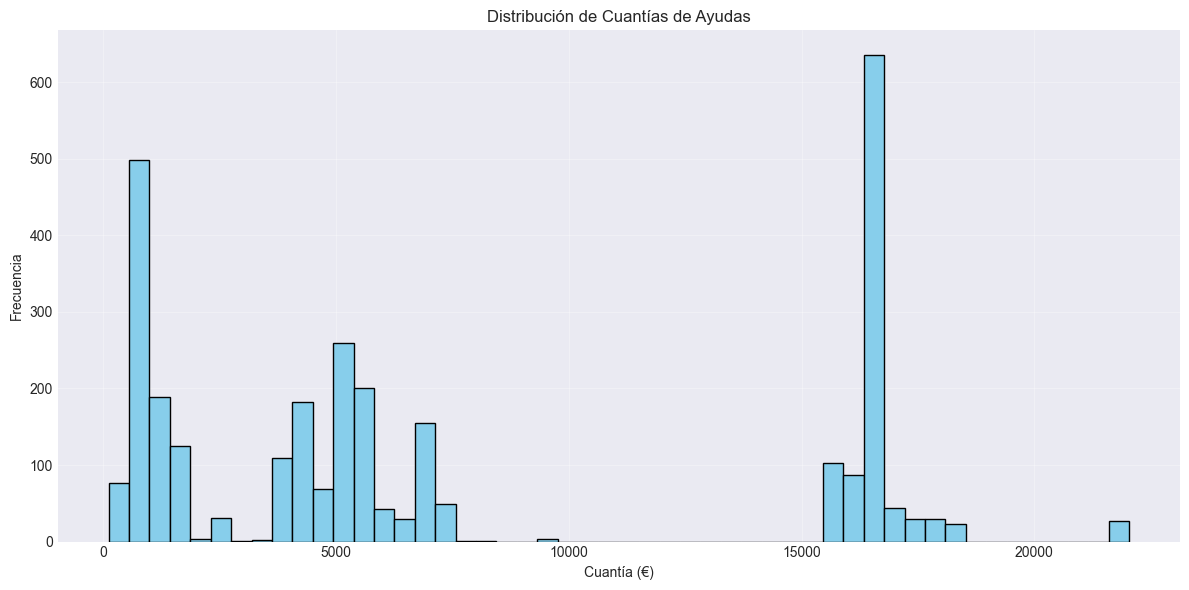


Estadísticas de cuantías:
count     3008.000000
mean      7712.054302
std       6513.465328
min        120.000000
25%       1277.420000
50%       5278.540000
75%      16422.000000
max      22031.520000
Name: cuantia_total, dtype: float64


In [53]:
# Histograma de cuantías
query = """
SELECT cuantia_total 
FROM ayuda 
WHERE cuantia_total IS NOT NULL AND cuantia_total > 0;
"""

df_cuantias = pd.read_sql_query(query, conn)

fig, ax = plt.subplots(figsize=(12, 6))
df_cuantias['cuantia_total'].hist(bins=50, ax=ax, color='skyblue', edgecolor='black')
ax.set_xlabel('Cuantía (€)')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Cuantías de Ayudas')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nEstadísticas de cuantías:")
print(df_cuantias['cuantia_total'].describe())

## 📋 4. Análisis de Licitaciones

### 4.1 Top Licitaciones por Importe

In [54]:
# Top 10 licitaciones más grandes
query = """
SELECT 
    identificador,
    objeto_licitacion_o_lote,
    presupuesto_base_sin_impuestos_licitacion_o_lote as presupuesto_base,
    importe_adjudicacion_sin_impuestos_licitacion_o_lote as importe_adjudicacion,
    resultado_licitacion_o_lote,
    primera_publicacion
FROM licitacion
WHERE importe_adjudicacion_sin_impuestos_licitacion_o_lote IS NOT NULL
ORDER BY importe_adjudicacion_sin_impuestos_licitacion_o_lote DESC
LIMIT 10;
"""

df_top_licitaciones = pd.read_sql_query(query, conn)
df_top_licitaciones

/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/4129490010.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top_licitaciones = pd.read_sql_query(query, conn)


,identificador,objeto_licitacion_o_lote,presupuesto_base,importe_adjudicacion,resultado_licitacion_o_lote,primera_publicacion
0,16195599,Limpieza de los edificios y demÃ¡s dependencia...,4714704.39,4203785.54,Formalizado,2024-12-01
1,6225549,"servicio de limpieza, desratizaciÃ³n y desinse...",4555723.59,4047415.06,Adjudicado,2020-08-04
2,11449629,Limpieza de los edificios y demÃ¡s dependencia...,4893616.58,3988294.18,Formalizado,2022-10-28
3,2485298,"Servicio de limpieza, desinfecciÃ³n, desratiza...",4221480.00,3885994.36,Adjudicado,2018-10-01
4,3916214,Servicio de mantenimiento de los edificios e i...,3701790.64,3198057.00,Adjudicado,2019-07-30
5,9128722,âServicio de mantenimiento de los edificios ...,3173513.42,2727439.00,Adjudicado,2022-01-21
6,9265468,Suministro elÃ©ctrico en alta tensiÃ³n (AT),3541662.15,2669540.46,Adjudicado,2022-02-09
7,3470150,ConcesiÃ³n de servicios para la gestiÃ³n y exp...,2700000.00,2481552.00,Adjudicado,2019-04-10
8,4084460,ContrataciÃ³n de un servicio de seguridad en l...,1776877.18,1655900.00,Adjudicado,2019-09-25
9,15406888,Lote 1: Mantenimiento y soporte de los equipos...,1653000.00,1652900.00,Formalizado,2024-07-28


### 4.2 Estadísticas de Licitaciones por Resultado

In [55]:
# Distribución por resultado
query = """
SELECT 
    resultado_licitacion_o_lote,
    COUNT(*) as num_licitaciones,
    SUM(importe_adjudicacion_sin_impuestos_licitacion_o_lote) as total_adjudicado
FROM licitacion
WHERE resultado_licitacion_o_lote IS NOT NULL
GROUP BY resultado_licitacion_o_lote
ORDER BY num_licitaciones DESC;
"""

df_resultados = pd.read_sql_query(query, conn)
df_resultados

/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/914960591.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resultados = pd.read_sql_query(query, conn)


,resultado_licitacion_o_lote,num_licitaciones,total_adjudicado
0,Adjudicado,218,48101387.82
1,Formalizado,178,37488690.53
2,Desierto,30,NaN
3,Desistimiento,5,NaN
4,Renuncia,2,NaN


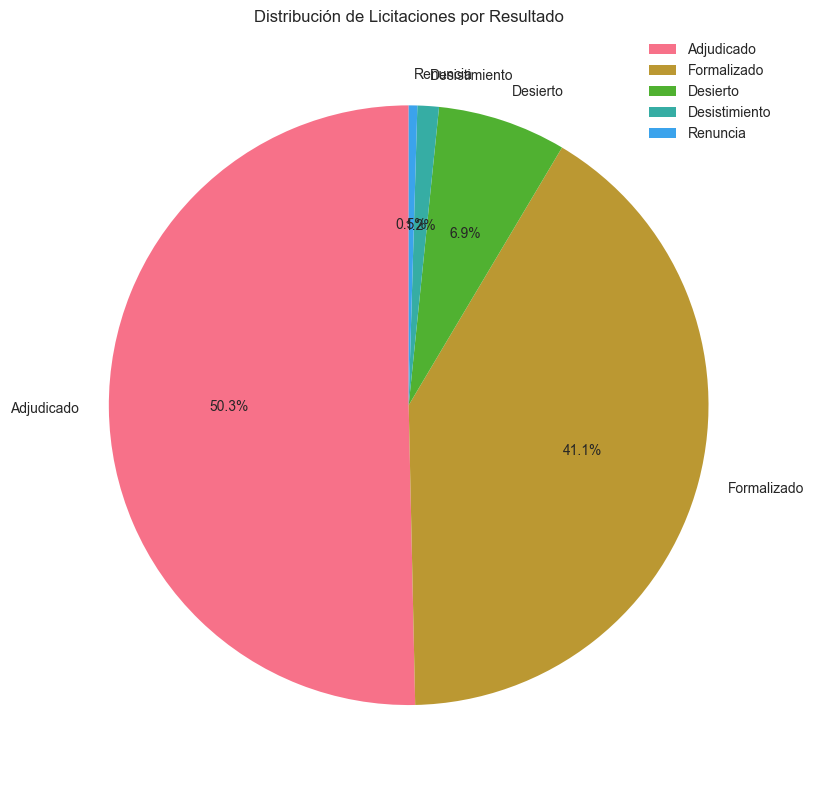

In [56]:
# Gráfico de pie de resultados
fig, ax = plt.subplots(figsize=(10, 8))
df_resultados.plot(
    y='num_licitaciones', 
    kind='pie', 
    labels=df_resultados['resultado_licitacion_o_lote'],
    ax=ax,
    autopct='%1.1f%%',
    startangle=90
)
ax.set_ylabel('')
ax.set_title('Distribución de Licitaciones por Resultado')
plt.tight_layout()
plt.show()

### 4.3 Evolución de Licitaciones en el Tiempo

/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/388234494.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_licit_anio = pd.read_sql_query(query, conn)


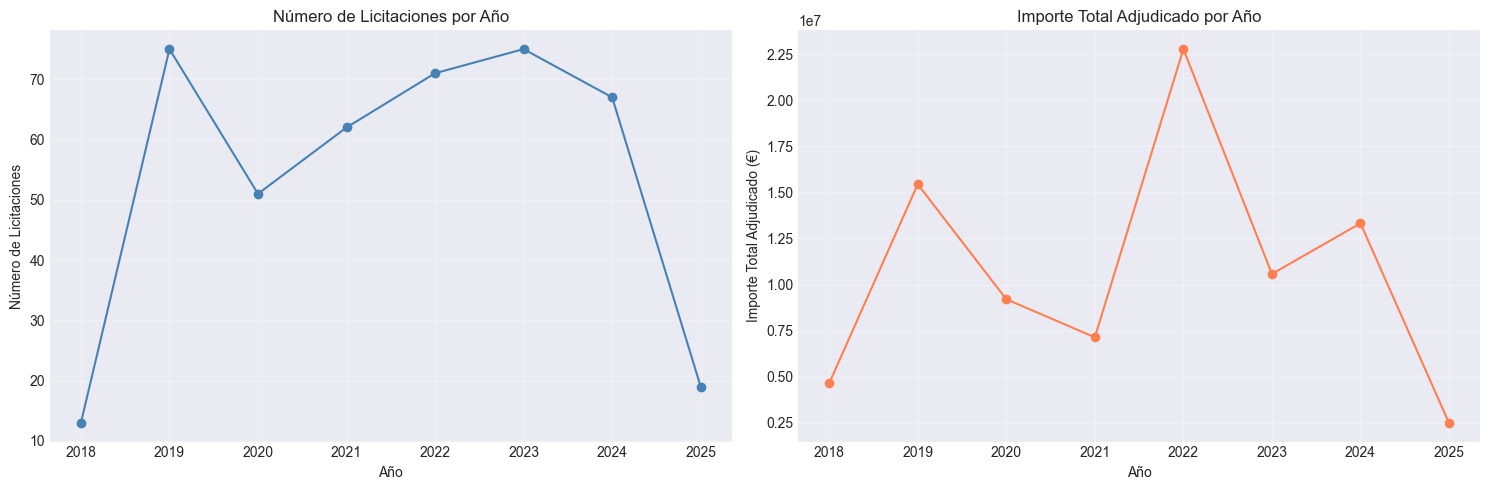

In [57]:
# Licitaciones por año
query = """
SELECT 
    EXTRACT(YEAR FROM primera_publicacion) as anio,
    COUNT(*) as num_licitaciones,
    SUM(importe_adjudicacion_sin_impuestos_licitacion_o_lote) as total_adjudicado
FROM licitacion
WHERE primera_publicacion IS NOT NULL
GROUP BY EXTRACT(YEAR FROM primera_publicacion)
ORDER BY anio;
"""

df_licit_anio = pd.read_sql_query(query, conn)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Número de licitaciones
df_licit_anio.plot(x='anio', y='num_licitaciones', ax=ax1, marker='o', color='steelblue')
ax1.set_xlabel('Año')
ax1.set_ylabel('Número de Licitaciones')
ax1.set_title('Número de Licitaciones por Año')
ax1.grid(True, alpha=0.3)
ax1.legend().remove()

# Gráfico 2: Importe total adjudicado
df_licit_anio.plot(x='anio', y='total_adjudicado', ax=ax2, marker='o', color='coral')
ax2.set_xlabel('Año')
ax2.set_ylabel('Importe Total Adjudicado (€)')
ax2.set_title('Importe Total Adjudicado por Año')
ax2.grid(True, alpha=0.3)
ax2.legend().remove()

plt.tight_layout()
plt.show()

## 🔍 5. Consultas Personalizadas

## 🔗 SPARQL en GraphDB

Configuración y consultas SPARQL contra el repositorio de GraphDB.

In [58]:
# Configuración de GraphDB y SPARQL
from SPARQLWrapper import SPARQLWrapper, JSON

GRAPHDB_URL = "http://localhost:8000"
REPOSITORY = "uam_data"  # Ajusta si el nombre difiere
SPARQL_ENDPOINT = f"{GRAPHDB_URL}/repositories/{REPOSITORY}"

sparql = SPARQLWrapper(SPARQL_ENDPOINT)
sparql.setReturnFormat(JSON)
print(f"✅ Endpoint SPARQL configurado: {SPARQL_ENDPOINT}")

✅ Endpoint SPARQL configurado: http://localhost:8000/repositories/uam_data


In [59]:
# Instalar dependencias para SPARQL (si es necesario)
# %pip install SPARQLWrapper

In [ ]:
# Comparación: misma consulta en SQL y SPARQL

print("="*60)
print("COMPARACIÓN SQL vs SPARQL")
print("="*60)

# Consulta SQL: Total de gastos por año
sql_query = """
SELECT anio, COUNT(*) as registros, SUM(credito_total) as total
FROM presupuesto_gastos
WHERE anio IS NOT NULL
GROUP BY anio
ORDER BY anio
LIMIT 5;
"""

print("\n🔵 SQL Query:")
print(sql_query)
df_sql_result = pd.read_sql_query(sql_query, conn)
print("\nResultado SQL:")
display(df_sql_result)

# Consulta SPARQL equivalente con provenance -> Distribution -> añoFiscal
sparql_query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>
PREFIX g2_data: <https://www.mi-master.es/proyecto/datos/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?anio (COUNT(?gasto) as ?registros) (SUM(xsd:decimal(?credito)) as ?total)
WHERE {
  ?gasto rdf:type g2_ont:PartidaGasto ;
        schema:amount ?amountNode ;
        dcterms:provenance ?dist .
  ?amountNode schema:value ?credito .
  ?dist g2_ont:añoFiscal ?anio .
}
GROUP BY ?anio
ORDER BY ?anio
LIMIT 5
"""

print("\n🟢 SPARQL Query (Ontología UAM):")
print(sparql_query)

try:
    sparql.setQuery(sparql_query)
    results = sparql.query().convert()
    bindings = results["results"]["bindings"]
    
    if bindings:
        df_sparql_result = pd.DataFrame([
            {
                'anio': r.get('anio', {}).get('value', ''),
                'registros': int(r.get('registros', {}).get('value', 0)),
                'total': float(r.get('total', {}).get('value', 0))
            }
            for r in bindings
        ])
        print("\nResultado SPARQL:")
        display(df_sparql_result)
        
        print("\n📊 Comparación:")
        print(f"SQL retorna: {len(df_sql_result)} filas")
        print(f"SPARQL retorna: {len(df_sparql_result)} filas")
    else:
        print("\n⚠️ SPARQL no retornó resultados (verifica que los datos estén cargados en GraphDB)")
except Exception as e:
    print(f"\n❌ Error en consulta SPARQL: {e}")
    print("   (Verifica que GraphDB esté corriendo y el repositorio exista)")

print("\n" + "="*60)

COMPARACIÓN SQL vs SPARQL

🔵 SQL Query:

SELECT anio, COUNT(*) as registros, SUM(credito_total) as total
FROM presupuesto_gastos
WHERE anio IS NOT NULL
GROUP BY anio
ORDER BY anio
LIMIT 5;


Resultado SQL:


/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/1193222483.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_result = pd.read_sql_query(sql_query, conn)


,anio,registros,total
0,2017,8251,2.883932e+08
1,2018,8346,2.954302e+08
2,2019,8179,3.154899e+08
3,2020,15559,3.260863e+08
4,2021,8859,6.813788e+08



🟢 SPARQL Query:

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX uam: <http://uam.es/ontology/>

SELECT ?anio (COUNT(?presupuesto) as ?registros) (SUM(?credito) as ?total)
WHERE {
  ?presupuesto rdf:type uam:PresupuestoGasto .
  ?presupuesto uam:anio ?anio .
  ?presupuesto uam:creditoTotal ?credito .
}
GROUP BY ?anio
ORDER BY ?anio
LIMIT 5


❌ Error en consulta SPARQL: EndPointNotFound: It was not possible to connect to the given endpoint: check it is correct. 

Response:
b'Unknown repository: uam_data'
   (Esto es normal si aún no has cargado datos RDF en GraphDB)


❌ Error en consulta SPARQL: EndPointNotFound: It was not possible to connect to the given endpoint: check it is correct. 

Response:
b'Unknown repository: uam_data'
   (Esto es normal si aún no has cargado datos RDF en GraphDB)



### Consulta 7: Comparación SQL vs SPARQL

In [ ]:
# Consulta SPARQL con filtros y regex - ACTUALIZADA
query_filter = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>

SELECT ?licitacion ?objeto ?importe ?fecha
WHERE {
  ?licitacion rdf:type g2_ont:Licitacion .
  ?licitacion dcterms:description ?objeto .
  ?licitacion schema:amount ?amountNode .
  ?amountNode schema:value ?importe .
  OPTIONAL { ?licitacion schema:url ?fecha } .
  
  FILTER(REGEX(?objeto, "software|informática|tecnología", "i"))
  FILTER(?importe > 10000)
}
ORDER BY DESC(?importe)
LIMIT 10
"""

try:
    sparql.setQuery(query_filter)
    results = sparql.query().convert()
    
    bindings = results["results"]["bindings"]
    if bindings:
        df_licit_sparql = pd.DataFrame([
            {
                'objeto': r.get('objeto', {}).get('value', 'N/A')[:60] + '...',
                'importe': float(r.get('importe', {}).get('value', 0)),
                'fecha': r.get('fecha', {}).get('value', 'N/A')
            }
            for r in bindings
        ])
        print(f"✅ Encontradas {len(df_licit_sparql)} licitaciones de tecnología")
        display(df_licit_sparql)
    else:
        print("⚠️ No se encontraron licitaciones con los criterios especificados.")
except Exception as e:
    print(f"❌ Error: {e}")

❌ Error: EndPointNotFound: It was not possible to connect to the given endpoint: check it is correct. 

Response:
b'Unknown repository: uam_data'


### Consulta 6: SPARQL con FILTER y expresiones regulares

In [ ]:
# Consulta SPARQL con agregación - ACTUALIZADA
query_agregacion = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>

SELECT ?capitulo (SUM(?credito) as ?total) (COUNT(?presupuesto) as ?numRegistros)
WHERE {
  ?presupuesto rdf:type g2_ont:PartidaGasto .
  ?presupuesto g2_ont:capitulo ?capitulo .
  ?presupuesto schema:amount ?amountNode .
  ?amountNode schema:value ?credito .
}
GROUP BY ?capitulo
ORDER BY DESC(?total)
LIMIT 10
"""

try:
    sparql.setQuery(query_agregacion)
    results = sparql.query().convert()
    
    bindings = results["results"]["bindings"]
    if bindings:
        df_agregacion = pd.DataFrame([
            {
                'capitulo': r.get('capitulo', {}).get('value', 'N/A'),
                'total': float(r.get('total', {}).get('value', 0)),
                'num_registros': int(r.get('numRegistros', {}).get('value', 0))
            }
            for r in bindings
        ])
        df_agregacion['total_millones'] = df_agregacion['total'] / 1_000_000
        print(f"✅ Agregación completada: {len(df_agregacion)} capítulos")
        display(df_agregacion[['capitulo', 'total_millones', 'num_registros']])
        
        # Visualización
        fig, ax = plt.subplots(figsize=(12, 6))
        df_agregacion.plot(x='capitulo', y='total_millones', kind='barh', ax=ax, color='mediumseagreen')
        ax.set_xlabel('Total (Millones €)')
        ax.set_ylabel('Capítulo')
        ax.set_title('Agregación SPARQL: Total por Capítulo')
        ax.legend().remove()
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No se pudieron agregar datos.")
except Exception as e:
    print(f"❌ Error: {e}")

❌ Error: EndPointNotFound: It was not possible to connect to the given endpoint: check it is correct. 

Response:
b'Unknown repository: uam_data'


### Consulta 5: Agregación SPARQL - Total por Capítulo

In [ ]:
# Consulta SPARQL: ayudas con sus convocatorias - ACTUALIZADA
query_ayudas = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>

SELECT ?ayuda ?convocatoria ?nombreConv ?categoria ?cuantia
WHERE {
  ?ayuda rdf:type g2_ont:AyudaConcedida .
  ?ayuda g2_ont:convocatoriaAsociada ?convocatoria .
  ?ayuda schema:amount ?amountNode .
  ?amountNode schema:value ?cuantia .
  
  ?convocatoria schema:name ?nombreConv .
  OPTIONAL { ?convocatoria dcterms:description ?categoria } .
  
  FILTER(?cuantia > 0)
}
ORDER BY DESC(?cuantia)
LIMIT 10
"""

try:
    sparql.setQuery(query_ayudas)
    results = sparql.query().convert()
    
    bindings = results["results"]["bindings"]
    if bindings:
        df_ayudas_sparql = pd.DataFrame([
            {
                'convocatoria': r.get('nombreConv', {}).get('value', 'N/A'),
                'categoria': r.get('categoria', {}).get('value', 'N/A'),
                'cuantia': float(r.get('cuantia', {}).get('value', 0))
            }
            for r in bindings
        ])
        print(f"✅ Encontradas {len(df_ayudas_sparql)} ayudas")
        display(df_ayudas_sparql)
    else:
        print("⚠️ No se encontraron ayudas en el grafo.")
except Exception as e:
    print(f"❌ Error: {e}")

❌ Error: EndPointNotFound: It was not possible to connect to the given endpoint: check it is correct. 

Response:
b'Unknown repository: uam_data'


### Consulta 4: Ayudas y sus convocatorias (SPARQL JOIN)

In [ ]:
# Consulta SPARQL: presupuestos de gastos - ACTUALIZADA (usando provenance -> añoFiscal)
query_presupuestos = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?presupuesto ?anio ?capitulo ?creditoTotal
WHERE {
  ?presupuesto rdf:type g2_ont:PartidaGasto ;
               g2_ont:capitulo ?capitulo ;
               schema:amount ?amountNode ;
               dcterms:provenance ?dist .
  ?amountNode schema:value ?creditoTotal .
  ?dist g2_ont:añoFiscal ?anio .
  
  FILTER(?creditoTotal > 1000000)
}
ORDER BY DESC(?creditoTotal)
LIMIT 15
"""

try:
    sparql.setQuery(query_presupuestos)
    results = sparql.query().convert()
    
    bindings = results["results"]["bindings"]
    if bindings:
        df_presu_sparql = pd.DataFrame([
            {
                'año': r.get('anio', {}).get('value', ''),
                'capitulo': r.get('capitulo', {}).get('value', ''),
                'credito_total': float(r.get('creditoTotal', {}).get('value', 0))
            }
            for r in bindings
        ])
        df_presu_sparql['credito_millones'] = df_presu_sparql['credito_total'] / 1_000_000
        print(f"✅ Encontrados {len(df_presu_sparql)} presupuestos > 1M€")
        display(df_presu_sparql)
    else:
        print("⚠️ No se encontraron presupuestos en el grafo.")
except Exception as e:
    print(f"❌ Error: {e}")

❌ Error: EndPointNotFound: It was not possible to connect to the given endpoint: check it is correct. 

Response:
b'Unknown repository: uam_data'


### Consulta 3: Presupuestos relacionados con la UAM

In [ ]:
# Consulta SPARQL: buscar universidades - ACTUALIZADA
query_universidades = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>

SELECT ?universidad ?nombre ?codigo ?vatID ?wikidata ?dbpedia
WHERE {
  ?universidad rdf:type g2_ont:Universidad .
  OPTIONAL { ?universidad schema:name ?nombre } .
  OPTIONAL { ?universidad dcterms:identifier ?codigo } .
  OPTIONAL { ?universidad schema:vatID ?vatID } .
  OPTIONAL { 
    ?universidad owl:sameAs ?externalLink .
    FILTER(CONTAINS(STR(?externalLink), "wikidata"))
    BIND(?externalLink as ?wikidata)
  }
  OPTIONAL { 
    ?universidad owl:sameAs ?externalLink2 .
    FILTER(CONTAINS(STR(?externalLink2), "dbpedia"))
    BIND(?externalLink2 as ?dbpedia)
  }
}
"""

try:
    sparql.setQuery(query_universidades)
    results = sparql.query().convert()
    
    bindings = results["results"]["bindings"]
    if bindings:
        df_unis = pd.DataFrame([
            {
                'universidad': r.get('universidad', {}).get('value', ''),
                'nombre': r.get('nombre', {}).get('value', 'N/A'),
                'codigo': r.get('codigo', {}).get('value', 'N/A'),
                'vatID': r.get('vatID', {}).get('value', 'N/A'),
                'wikidata': r.get('wikidata', {}).get('value', 'N/A'),
                'dbpedia': r.get('dbpedia', {}).get('value', 'N/A')
            }
            for r in bindings
        ])
        print(f"✅ Encontradas {len(df_unis)} universidades")
        display(df_unis)
    else:
        print("⚠️ No se encontraron universidades en el grafo.")
except Exception as e:
    print(f"❌ Error: {e}")

❌ Error: EndPointNotFound: It was not possible to connect to the given endpoint: check it is correct. 

Response:
b'Unknown repository: uam_data'


### Consulta 2: Buscar entidades de tipo Universidad

In [ ]:
# Consulta SPARQL básica: obtener todos los triples - ACTUALIZADA
query_all_triples = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX g2_ont: <https://www.mi-master.es/proyecto/ontologia#>
PREFIX g2_data: <https://www.mi-master.es/proyecto/datos/>
PREFIX g2_uni: <https://www.mi-master.es/proyecto/entidad/>

SELECT ?subject ?predicate ?object
WHERE {
  ?subject ?predicate ?object .
  # Filtrar solo triples de nuestro dominio
  FILTER(
    STRSTARTS(STR(?subject), STR(g2_data:)) ||
    STRSTARTS(STR(?subject), STR(g2_uni:)) ||
    STRSTARTS(STR(?subject), STR(g2_ont:))
  )
}
LIMIT 20
"""

try:
    sparql.setQuery(query_all_triples)
    results = sparql.query().convert()
    
    # Convertir a DataFrame
    bindings = results["results"]["bindings"]
    if bindings:
        df_triples = pd.DataFrame([
            {
                'subject': r['subject']['value'][-50:],  # Últimos 50 caracteres para mejor visualización
                'predicate': r['predicate']['value'].split('#')[-1].split('/')[-1],  # Solo el nombre de la propiedad
                'object': str(r['object']['value'])[:50]  # Primeros 50 caracteres
            }
            for r in bindings
        ])
        print(f"✅ Recuperados {len(df_triples)} triples de nuestra ontología")
        display(df_triples)
    else:
        print("⚠️ No se encontraron triples. Verifica que el repositorio tenga datos cargados.")
except Exception as e:
    print(f"❌ Error al consultar GraphDB: {e}")
    print(f"   Verifica que GraphDB esté ejecutándose en {GRAPHDB_URL}")
    print(f"   y que el repositorio '{REPOSITORY}' exista.")

❌ Error al consultar GraphDB: EndPointNotFound: It was not possible to connect to the given endpoint: check it is correct. 

Response:
b'Unknown repository: uam_data'
   Verifica que GraphDB esté ejecutándose en http://localhost:8000
   y que el repositorio 'uam_data' exista.


### Consulta 1: Listar todos los triples (limitado)

In [67]:
# Ejemplo: Buscar licitaciones relacionadas con "software" o "informática"
query = """
SELECT 
    objeto_licitacion_o_lote,
    importe_adjudicacion_sin_impuestos_licitacion_o_lote,
    resultado_licitacion_o_lote,
    primera_publicacion
FROM licitacion
WHERE LOWER(objeto_licitacion_o_lote) LIKE '%software%'
   OR LOWER(objeto_licitacion_o_lote) LIKE '%informática%'
   OR LOWER(objeto_licitacion_o_lote) LIKE '%informatica%'
ORDER BY importe_adjudicacion_sin_impuestos_licitacion_o_lote DESC NULLS LAST
LIMIT 10;
"""

df_software = pd.read_sql_query(query, conn)
print("\n🖥️ Licitaciones relacionadas con Software/Informática:")
df_software


🖥️ Licitaciones relacionadas con Software/Informática:


/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/72945333.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_software = pd.read_sql_query(query, conn)


,objeto_licitacion_o_lote,importe_adjudicacion_sin_impuestos_licitacion_o_lote,resultado_licitacion_o_lote,primera_publicacion
0,Lote 1: Mantenimiento y soporte de los equipos...,1652900.00,Formalizado,2024-07-28
1,Servicio de mantenimiento y soporte de los equ...,1652000.00,Adjudicado,2019-07-31
2,Equipos de electrÃ³nica de red cableada y soft...,605163.97,Adjudicado,2021-11-02
3,ContrataciÃ³n del acuerdo denominado âEnterp...,360000.00,Formalizado,2023-10-13
4,Contrato ELA para el mantenimiento del softwar...,262000.00,Adjudicado,2018-12-03
5,Sistema de MicroscopÃ­a Confocal de alta veloc...,210000.00,Adjudicado,2021-06-21
6,"Servicio de mantenimiento y soporte tÃ©cnico, ...",152280.00,Adjudicado,2019-12-20
7,Equipo analizador de adsorciÃ³n de gases y vap...,116450.00,Formalizado,2022-09-14
8,RenovaciÃ³n de licencias de software Oracle We...,90490.00,Adjudicado,2022-02-15
9,RenovaciÃ³n de licencias de software Oracle We...,90190.00,Adjudicado,2020-12-22


/var/folders/2_/cf0ml5t95zgc_8wvnwkzs1z40000gn/T/ipykernel_33796/1552701897.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_balance = pd.read_sql_query(query, conn)


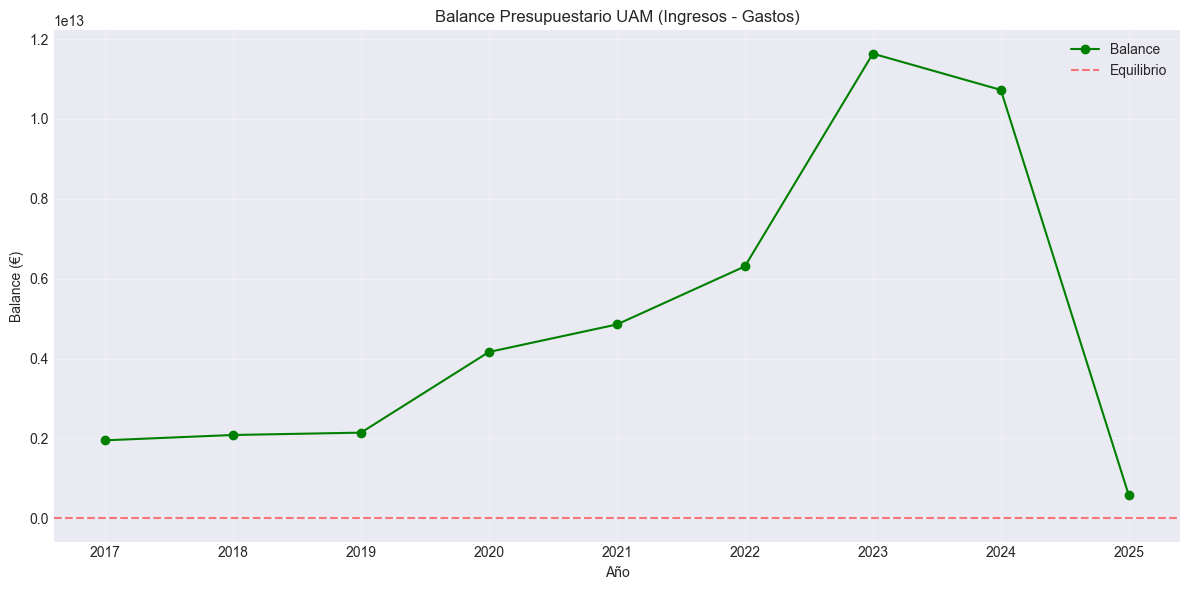

,anio,total_gastos,total_ingresos,balance
0,2017,4.256684e+11,2.379533e+12,1.953864e+12
1,2018,3.781507e+11,2.465661e+12,2.087510e+12
2,2019,4.344295e+11,2.580392e+12,2.145962e+12
3,2020,9.078244e+11,5.073577e+12,4.165753e+12
4,2021,1.181511e+12,6.036335e+12,4.854824e+12
5,2022,1.735884e+12,8.045004e+12,6.309120e+12
6,2023,1.681149e+12,1.331747e+13,1.163632e+13
7,2024,1.660521e+12,1.238865e+13,1.072813e+13
8,2025,1.823118e+11,7.580858e+11,5.757739e+11


In [68]:
# Análisis de gastos vs ingresos por año
query = """
SELECT 
    COALESCE(g.anio, i.anio) as anio,
    COALESCE(SUM(g.credito_total), 0) as total_gastos,
    COALESCE(SUM(i.credito_total), 0) as total_ingresos,
    COALESCE(SUM(i.credito_total), 0) - COALESCE(SUM(g.credito_total), 0) as balance
FROM presupuesto_gastos g
FULL OUTER JOIN presupuesto_ingresos i ON g.anio = i.anio
WHERE COALESCE(g.anio, i.anio) IS NOT NULL
GROUP BY COALESCE(g.anio, i.anio)
ORDER BY anio;
"""

df_balance = pd.read_sql_query(query, conn)

fig, ax = plt.subplots(figsize=(12, 6))
df_balance.plot(x='anio', y='balance', ax=ax, marker='o', color='green')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Año')
ax.set_ylabel('Balance (€)')
ax.set_title('Balance Presupuestario UAM (Ingresos - Gastos)')
ax.grid(True, alpha=0.3)
ax.legend(['Balance', 'Equilibrio'])
plt.tight_layout()
plt.show()

df_balance

## 📊 6. Resumen Final

In [69]:
# Dashboard resumen
print("="*60)
print("📊 RESUMEN EJECUTIVO - DATOS UAM")
print("="*60)

# Total registros
total_registros = df_resumen['registros'].sum()
print(f"\n📁 Total de registros procesados: {total_registros:,}")

# Rango temporal
anios = df_presupuesto['anio'].dropna().astype(int)
if len(anios) > 0:
    print(f"📅 Período: {anios.min()} - {anios.max()} ({anios.max() - anios.min() + 1} años)")

# Presupuesto total
total_gastos = df_presupuesto['total_gastos'].sum()
total_ingresos = df_presupuesto['total_ingresos'].sum()
print(f"\n💰 Presupuesto acumulado:")
print(f"   - Gastos: {total_gastos:,.2f} €")
print(f"   - Ingresos: {total_ingresos:,.2f} €")
print(f"   - Balance: {total_ingresos - total_gastos:,.2f} €")

# Ayudas
total_ayudas = df_ayudas_cat['num_ayudas'].sum()
total_cuantia_ayudas = df_ayudas_cat['total_cuantia'].sum()
print(f"\n🎓 Ayudas:")
print(f"   - Total concedidas: {total_ayudas:,}")
print(f"   - Cuantía total: {total_cuantia_ayudas:,.2f} €")
if total_ayudas > 0:
    print(f"   - Media por ayuda: {total_cuantia_ayudas/total_ayudas:,.2f} €")

# Licitaciones
total_licitaciones = df_resultados['num_licitaciones'].sum()
total_adjudicado = df_resultados['total_adjudicado'].sum()
print(f"\n📋 Licitaciones:")
print(f"   - Total procesadas: {total_licitaciones:,}")
print(f"   - Importe total adjudicado: {total_adjudicado:,.2f} €")

print("\n" + "="*60)
print("✅ Análisis completado exitosamente")
print("="*60)

📊 RESUMEN EJECUTIVO - DATOS UAM

📁 Total de registros procesados: 116,856
📅 Período: 2017 - 2025 (9 años)

💰 Presupuesto acumulado:
   - Gastos: 4,595,529,862.60 €
   - Ingresos: 4,596,418,751.96 €
   - Balance: 888,889.36 €

🎓 Ayudas:
   - Total concedidas: 6,390
   - Cuantía total: 23,197,859.34 €
   - Media por ayuda: 3,630.34 €

📋 Licitaciones:
   - Total procesadas: 433
   - Importe total adjudicado: 85,590,078.35 €

✅ Análisis completado exitosamente


## 🔒 Cerrar Conexión

In [70]:
# Cerrar la conexión a la base de datos
conn.close()
print("✅ Conexión cerrada")

✅ Conexión cerrada
